# Testing BIBIMBpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import agama

agama.setUnits(mass = 1, length = 1, velocity = 1)

In [3]:
import bibimbpy

## create initial conditions

In [4]:
r_ic = 8
phi_ic = 0
z_ic = 0
vz_ic = 0

vr_ic = np.linspace(-100,100,100)
vphi_ic = np.linspace(-400,-100,100)

In [5]:
ic = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [6]:
ic.shape

(10000, 6)

## Generate axisymmetric potential

In [7]:
pbase = agama.Potential("../../../../Google Drive/My Drive/Recerca/Notebooks/DiscDynamics/Potentials/McMillan17.ini")



## Generate perturbation and its m=0 mode

### generate scaling file

In [8]:
bibimbpy.utils.generate_scaling_file(1,"dehnen",100,"test_scaling_file.txt")

In [32]:
pert_params_dict = {"type":"Ferrers","mass":1e10,"scaleRadius":5,"axisRatioY":0.8,"axisRatioZ":0.2,
                   "scale":"test_scaling_file.txt"}


In [33]:
pot_pertuber = agama.Potential(**pert_params_dict)

scaling_file = pert_params_dict["scale"]

#make the static part
pert_params_dict.pop("scale")
pot_pertuber_static = agama.Potential(**pert_params_dict)
pot_pertuber_m0_static = agama.Potential(type='CylSpline', potential=pot_pertuber_static, 
                                         mmax=0, rmin=0, rmax=20)
pot_pertuber_m0 = agama.Potential(type='CylSpline', potential=pot_pertuber_static, mmax=0, rmin=0, rmax=20, 
                                    scale=bibimbpy.utils.invert_scaling_file(scaling_file))

In [34]:
pbase_m0 = agama.Potential(pbase,pot_pertuber_m0_static)

In [35]:
r_ = np.linspace(0,15,100)
phi_ = np.linspace(0,2*np.pi,100)

R,PHI = np.meshgrid(r_,phi_)

r = R.flatten()
phi = PHI.flatten()

z = np.zeros_like(r)
points = np.column_stack((r*np.cos(phi),r*np.sin(phi),z))
points_line = np.column_stack((r_,r_*0,r_*0))

In [36]:
pm0_stat_eval = pot_pertuber_m0_static.potential(points)

pm0_stat_force = pot_pertuber_m0_static.force(points_line)
pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)

pm0_stat_base_force = pbase_m0.force(points_line)
pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_28765/4057661711.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)
/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_28765/4057661711.py:7: RuntimeWarning: invalid value encountered in divide
  pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)


In [54]:
t0 = 0

In [55]:
pm0_eval = pot_pertuber_m0.potential(points,t=t0)

pm0_force = pot_pertuber_m0.force(points_line,t=t0)
pm0_omega = np.sqrt(-pm0_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_28765/4203405552.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_omega = np.sqrt(-pm0_force[:,0]/r_)


In [56]:
ppert_eval = pot_pertuber.potential(points,t=t0)

ppert_force = pot_pertuber.force(points_line,t=t0)
ppert_omega = np.sqrt(-ppert_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_28765/425372579.py:4: RuntimeWarning: invalid value encountered in divide
  ppert_omega = np.sqrt(-ppert_force[:,0]/r_)
/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_28765/425372579.py:4: RuntimeWarning: invalid value encountered in sqrt
  ppert_omega = np.sqrt(-ppert_force[:,0]/r_)


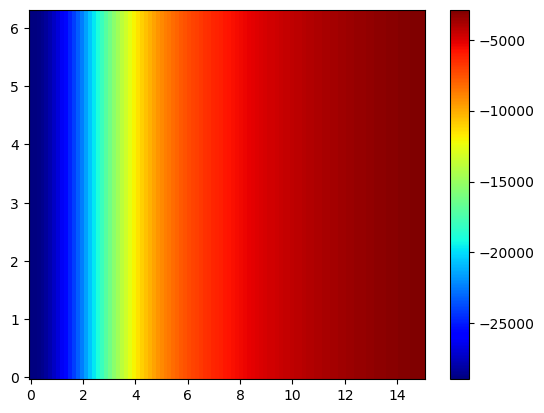

In [57]:
plt.pcolormesh(R,PHI,pm0_stat_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

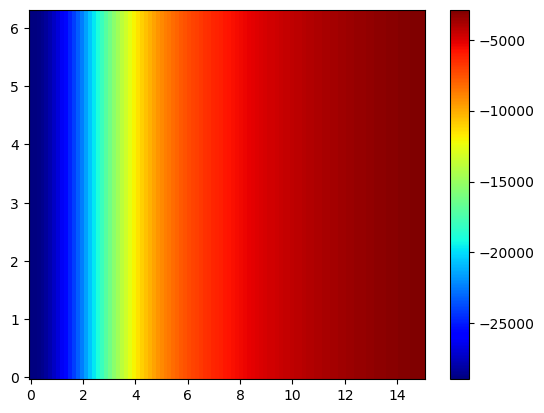

In [58]:
plt.pcolormesh(R,PHI,pm0_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

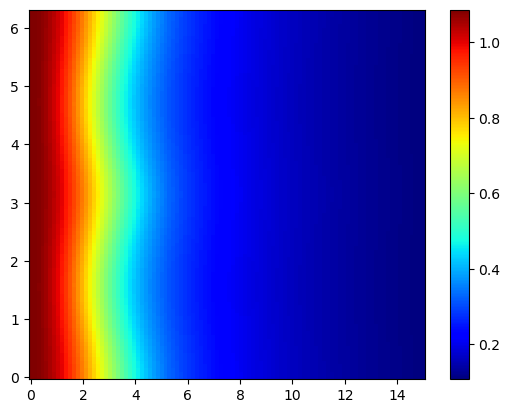

In [59]:
plt.pcolormesh(R,PHI,ppert_eval.reshape(R.shape),cmap="jet")
plt.colorbar()

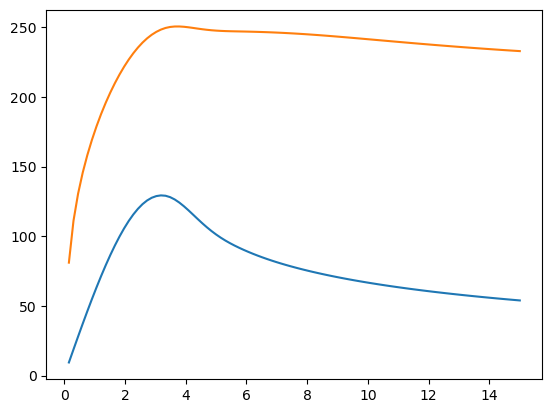

In [60]:
plt.plot(r_,r_*pm0_stat_omega)
plt.plot(r_,r_*pm0_stat_base_omega)

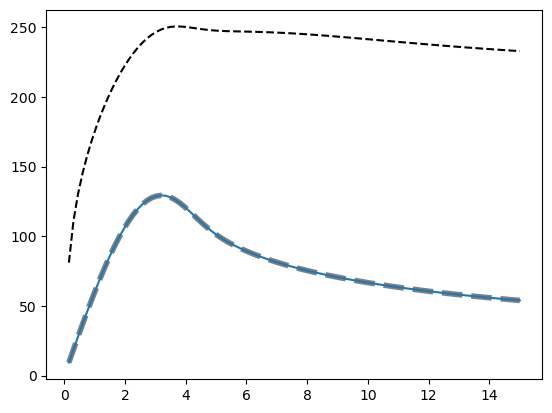

In [62]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*pm0_stat_omega,ls="--",color="grey",lw=4)
plt.plot(r_,r_*pm0_omega)
plt.plot(r_,r_*ppert_omega)

## Generate DF

In [22]:
df = agama.DistributionFunction(type="QuasiIsothermal", Sigma0 = 1., Rdisk = 2.5, Hdisk = 0.3, 
                                Rsigmar = 5., sigmar0 = 35./np.exp(-8./5.), potential = pbase)